# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn import train_nn as tnn

In [2]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg_230901.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)

ecl_oligo_df = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv', index_col=0)

## Model for stack parameter plotting

(27732, 1338)
CPU times: user 2min 43s, sys: 2min 21s, total: 5min 5s
Wall time: 1min 29s


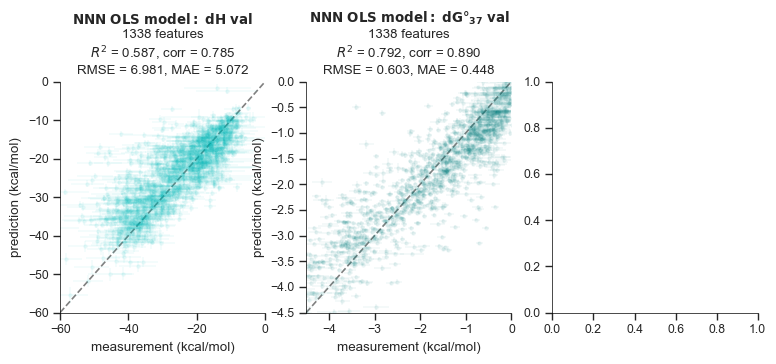

In [63]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=False, ignore_base_stack=False)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 3, figsize=(9,3))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

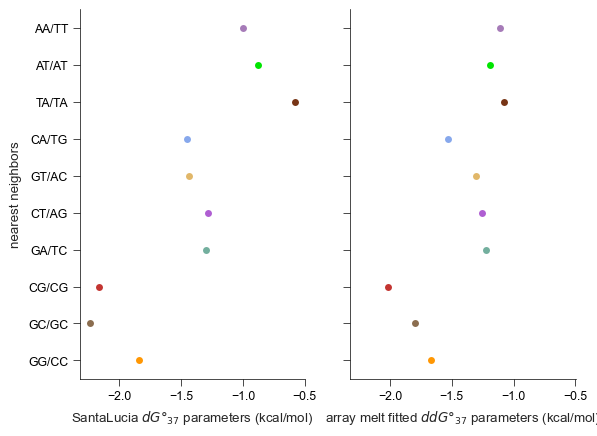

In [66]:
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

santa_lucia['feats'] = santa_lucia['motif'].apply(lambda x: x.replace('_','+') + '_((+))')
coef_df = lr_dict['dG'].coef_df.join(lr_dict['dH'].coef_df.rename(columns={'dG_37':'dH'}))
fit_vs_sl = santa_lucia.set_index('feats').join(
    coef_df, 
    lsuffix='_SantaLucia', rsuffix='_NNN')
fit_vs_sl['nearest neighbors'] = fit_vs_sl['motif'].apply(lambda x: x.replace('_','/'))
fit_vs_sl['dG_37_NNN'] +=  - np.mean(fit_vs_sl['dG_37_NNN']) + np.mean(fit_vs_sl['dG_37_SantaLucia'])
fit_vs_sl['dH_NNN'] +=  - np.mean(fit_vs_sl['dH_NNN']) + np.mean(fit_vs_sl['dH_SantaLucia'])

"""dG"""
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_SantaLucia', ax=ax[0], palette='cet_glasbey_dark')
ax[0].set_xlabel(r'SantaLucia $dG°_{37}$ parameters (kcal/mol)')
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_NNN', ax=ax[1], palette='cet_glasbey_dark')
ax[1].set_xlabel(r'array melt fitted $ddG°_{37}$ parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax)
util.save_fig('./fig/Fig4/NN_param_ArrayMelt_vs_SantaLucia_dG_37.pdf')

## 1-step linear regression

Trying to minimize manual model engineering...

### Train

In [52]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False, directly_fit_3_4_hairpin_loop=False)
print(feats.shape)

(27732, 178)
CPU times: user 15.3 s, sys: 343 ms, total: 15.7 s
Wall time: 15.4 s


In [53]:
""" Fixed parameters during training """
param_set_template_file = './models/dna04.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)
print(len(fixed_feature_names))

fixed_feature_names = [x for x in fixed_feature_names if x in feats.columns]
print('#fixed features =', len(fixed_feature_names))

316
#fixed features = 10


Fitting dH
Fitting dG
CPU times: user 10.5 s, sys: 22.1 s, total: 32.6 s
Wall time: 25.4 s


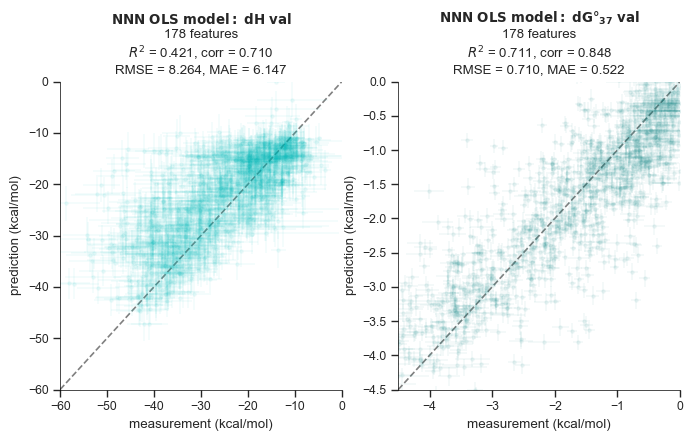

In [54]:
%%time 
"""
Fit with standard SVD
"""
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()
param_name_dict = dict(dH='dH', dG='dG_37')
for i,param in enumerate(param_name_dict):
    print("Fitting", param)
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                                  method='svd',
                                  fix_some_coef=True, 
                                  fix_coef_kwargs=dict(fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]]),
                                  )

In [ ]:
%%time 
"""
Fit with regularization
"""
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()
param_name_dict = dict(dH='dH', dG='dG_37')
for i,param in enumerate(param_name_dict):
    print("Fitting", param)
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                                  method='regularized',
                                  fix_some_coef=True, 
                                  fix_coef_kwargs=dict(fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]]),
                                  regularization_kwargs=dict(reg_lambda=1e-2))

In [56]:
for param in lr_dict:
    print(param, '===')
    print(lr_dict[param].metrics)
    try:
        print(lr_dict[param].coef_df.loc['intercept#intercept'].values)
    except:
        pass

dH ===
{'rsqr': 0.4722876818992673, 'rmse': 8.047105615114935, 'mae': 6.0465106423965, 'dof': 24801, 'chisq': 26834085409.98048, 'redchi': 1081975.9449207888}
dG ===
{'rsqr': 0.7281971776284414, 'rmse': 0.6882034085051449, 'mae': 0.5258540442634877, 'dof': 24801, 'chisq': 199984769572.4907, 'redchi': 8063576.854662743}


### Save parameters to json

In [ ]:
lr_dict['dG'].coef_df.loc['intercept#intercept']

In [ ]:
param_set_template_file = './models/dna04.json'
param_set_file = './models/dna-nnn-intercept.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, 
                             lr_step='full', center_new_parameters=True,
                             comment='Add intercept parameter = %.4f, not regularized just svd, centering parameters' % lr_dict['dG'].coef_df.loc['intercept#intercept'])

In [58]:
param_set_template_file = './models/dna04.json'
param_set_file = './models/dna-nnn-stack.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, 
                             lr_step='full', center_new_parameters=True,
                             comment='Fitting WC stack parameters as well, no intercept')

Centering new parameters...
group bulge_size
group hairpin_mismatch
	Mean value of old_dict is -3.684
	Mean value of fitted new_dict is -16.889
	Mean value of centered new_dict is -3.684

group hairpin_size
group interior_mismatch
	Mean value of old_dict is -2.913
	Mean value of fitted new_dict is -5.053
	Mean value of centered new_dict is -2.913

group interior_size
group stack
	Mean value of old_dict is -8.275
	Mean value of fitted new_dict is -6.813
	Mean value of centered new_dict is -8.275

group terminal_penalty
	Mean value of old_dict is 1.100
	Mean value of fitted new_dict is -0.490
	Mean value of centered new_dict is 1.100

Centering new parameters...
group bulge_size
group hairpin_mismatch
	Mean value of old_dict is -0.715
	Mean value of fitted new_dict is -4.449
	Mean value of centered new_dict is -0.715

group hairpin_size
group interior_mismatch
	Mean value of old_dict is -0.640
	Mean value of fitted new_dict is -0.689
	Mean value of centered new_dict is -0.640

group inte

## Validation

### On array validation set

#### On a specific category

In [ ]:
hairpinloop_ind = [x for x in data_split_dict['test_ind'] if (x.startswith('MM')) and x in arr_adj.index]#[:50]
# hairpinloop_ind = [x for x in data_split_dict['test_ind'] if x in arr_adj.index]#[:50]

val_df = arr_adj.loc[hairpinloop_ind,:]
print(len(val_df))

In [ ]:
val_result_df_nnn

In [ ]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))
plotkwargs = dict(lim=[-6,5], alpha=.2, color=np.array([57,83,164])/256, linewidth=0.25, edgecolor='k')

# Calculate prediction
# val_result_df_nnn = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna-nnn-intercept.json',)
# val_result_df_nupack = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna04.json',)

val_result_df_nnn_intercept = val_result_df_nnn.copy()
val_result_df_nnn_intercept['dG_37_pred'] = val_result_df_nnn['dG_37_pred'] + lr_dict['dG'].coef_df.at['intercept#intercept', 'dG_37']

# Plotting
modeling.plot_validation_result(val_result_df_nnn_intercept, param='dG_37', ax=ax[0], **plotkwargs)
modeling.plot_validation_result(val_result_df_nupack, param='dG_37', ax=ax[1], **plotkwargs)

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(2))
    a.tick_params(colors='k', width=.5)
    
# util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_mismatches.pdf')

In [ ]:
# ori_param_set_dict = fileio.read_json('./models/dna04.json')

#### Predict all and plot by category

In [ ]:
hairpinloop_ind = [x for x in data_split_dict['test_ind'] if x in arr_adj.index]

val_df = arr_adj.loc[hairpinloop_ind,:]
print(len(val_df))

In [ ]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))
plotkwargs = dict(lim=[-7,5], alpha=.25, color=np.array([57,83,164])/256, linewidth=0)

# Calculate prediction
# val_result_df_nnn = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna-nnn-1step.json',)
# val_result_df_nupack = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna04.json',)

# Plotting
modeling.plot_validation_result(val_result_df_nnn, param='dG_37', ax=ax[0], **plotkwargs)
modeling.plot_validation_result(val_result_df_nupack, param='dG_37', ax=ax[1], **plotkwargs)

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(2))
    a.tick_params(colors='k', width=.5)
    
util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_mismatches.pdf')
val_result_df_nnn.to_csv('./data/models/out/val_result_df_dna-nnn-1step_array_test_set.csv')
val_result_df_nnn.to_csv('./data/models/out/val_result_df_dna04_array_test_set.csv')

In [ ]:
metric_dict = dict()
metric_dict['new'] = modeling.get_metric_dict(val_result_df_nnn_intercept, 'dG_37')
metric_dict['original'] = modeling.get_metric_dict(val_result_df_nupack, 'dG_37')
fig, ax = plt.subplots(1,2, figsize=(6,3))
modeling.plot_metric_bar(metric_dict, metric_name='mae', ax=ax[0])
modeling.plot_metric_bar(metric_dict, metric_name='corr', ax=ax[1])

util.save_fig('./fig/Fig4/Test/array_all_test_nupack.pdf')

In [ ]:
metric_dict['new'] = dict(new=metric_dict['new'])
metric_dict['original'] = dict(new=metric_dict['original'])

for key,v_df in dict(new=val_result_df_nnn, original=val_result_df_nupack).items():
    v_df = v_df.join(annotation['Series'])
    series_list = np.unique(v_df['Series'])
    
    for s in series_list:
        v_df_part = v_df.query('Series == "%s"' % s)
        if s == 'WatsonCrick':
            modeling.plot_validation_result_all_params(v_df_part)
        if len(v_df_part) > 10:
            metric_dict[key][s] = modeling.get_metric_dict(v_df_part, 'dG_37')

In [ ]:
df = pd.concat((pd.DataFrame(metric_dict['new']), pd.DataFrame(metric_dict['original']))).rename(columns={'new': 'All'})
df['parameter set'] = ['new', 'new', 'original', 'original']
df = df.reset_index(names='metric')
df = df.melt(id_vars=['metric', 'parameter set'])

In [ ]:
sns.barplot(data=df.query('metric == "mae"'), x='variable', y='value', hue='parameter set',
            palette='viridis', width=.6, edgecolor='k', linewidth=.5)
sns.despine()
util.save_fig('./fig/Fig4/Test/MAE_by_series.pdf')

In [ ]:
sns.barplot(data=df.query('metric == "corr"'), x='variable', y='value', hue='parameter set',
            palette='viridis', width=.6, edgecolor='k', linewidth=.5)
sns.despine()

#### MAE as a function of %data

In [194]:
wandb_df = pd.read_csv('./data/wandb/wandb_export_2023-10-31T22_27_44.865-07_00.csv')

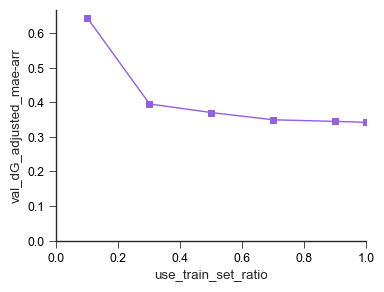

In [196]:
query = 'Tags != "nupack_test" & use_train_set_ratio <= 1'

fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(data=wandb_df.query(query), 
             x='use_train_set_ratio', y='val_dG_adjusted_mae-arr',
            ax=ax, c=np.array([148,94,234])/256, marker='s', markeredgecolor=None,linewidth=1)
# ax.set_ylim(bottom=0, top=.8)
ax.set_ylim(bottom=0)
ax.set_xlim([0,1])
plotting.beutify(ax)
util.save_fig('./fig/Fig4/mae.pdf')

### On UV melt data

#### A version freshly made

In [ ]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
result_agg_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
result_agg_df = result_agg_df[result_agg_df.index.isin(hplc_clean_seqid)]
uv_agg_df = result_agg_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean).join(annotation[['RefSeq', 'TargetStruct']])



for i,row in uv_agg_df.iterrows():
    if not isinstance(row.RefSeq, str):
        uv_agg_df.loc[i,'RefSeq'] = ecl_oligo_df.loc[row.name, 'sequence']
        oligo_len = len(ecl_oligo_df.loc[row.name, 'sequence'])
        stem_len = int((oligo_len - 4) / 2)
        target_struct = '('* stem_len + '....' + ')'* stem_len
        uv_agg_df.loc[i,'TargetStruct'] = target_struct

# val_df = uv_agg_df.copy()
# hairpinloop_ind = [x for x in uv_agg_df.index if ((x.startswith('HP')))]
hairpinloop_ind = [x for x in uv_agg_df.index]
val_df = uv_agg_df.loc[hairpinloop_ind]
val_df = val_df.rename(columns=lambda x: x.replace('_uv', ''))

In [ ]:
val_df.to_csv('./data/models/raw/uv.csv')

In [ ]:
%%time
val_result_df_uv_new = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-1step.json',)
metric_dict['uv_new'] = modeling.get_metric_dict(val_result_df_uv_new, 'dG_37')
modeling.plot_validation_result_all_params(val_result_df_uv_new)

In [ ]:
%%time
val_result_df_uv_original = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna04.json',)
metric_dict['uv_original'] = modeling.get_metric_dict(val_result_df_uv_original, 'dG_37')
modeling.plot_validation_result_all_params(val_result_df_uv_original)

In [ ]:
pd.DataFrame(metric_dict).to_clipboard()

In [ ]:
# modeling.plot_metric_bar(metric_dict)
# plt.show()
modeling.plot_metric_bar(metric_dict, metric_name='mae')
util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_and_uv.pdf')

In [ ]:
val_df_1 = val_df.copy()

### On Oliveira etc dataset

In [40]:
center_df = fileio.read_Oliveira_df('./data/literature/Oliveira_2020_mismatches.csv')
val_df = center_df.copy()

In [41]:
val_df = center_df.copy()
val_result_df_nupack = modeling.make_model_validation_df(val_df.iloc[:25,:], sodium=0.0675,
                                  model='nupack', model_param_file='./models/dna04.json',
                                  model_kwargs=dict(DNA_conc=1e-6))

val_result_df_nupack['n_mm'] = val_result_df_nupack.TargetStruct.apply(lambda x: int(x.count('.') / 2))

In [ ]:
val_result_df_nupack.to_csv('./data/models/out/Oliveira_val_result_df_dna04_no_water_molarity.csv')

In [ ]:
val_result_df_nupack = pd.read_csv('./data/models/out/Oliveira_val_result_df_dna04_no_water_molarity.csv', index_col=0)

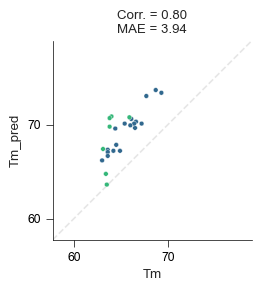

In [42]:
fig, ax = plt.subplots(figsize=(3,3))
modeling.plot_validation_result(val_result_df_nupack, 'Tm', ax=ax, hue='n_mm', palette='viridis', alpha=1)
util.beutify(ax, x_locator=10, y_locator=10)
# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_by_n_mm.pdf')

IndexError: cannot do a non-empty take from an empty axes.

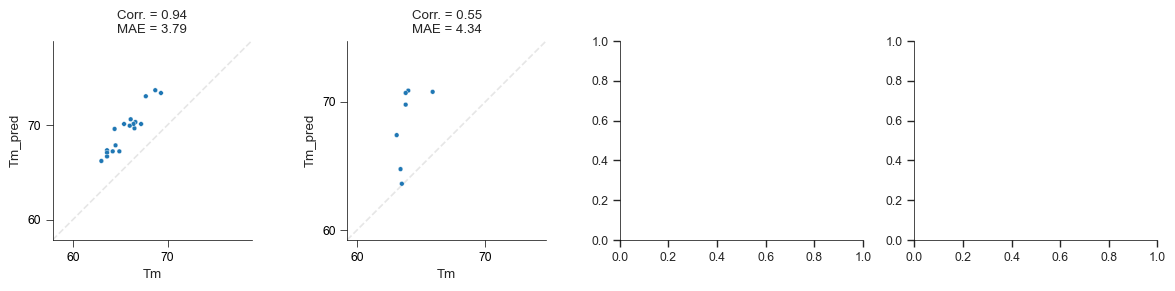

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for n in range(4):
    modeling.plot_validation_result(val_result_df_nupack.query('n_mm == %d'%n), 'Tm', ax=ax[n], 
                                    lim=None)
    util.beutify(ax[n], x_locator=10, y_locator=10)

# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_split_by_n_mm_centered.pdf')

In [47]:
val_result_df_nnn = modeling.make_model_validation_df(val_df.iloc[-25:,], sodium=0.0675,
                                  model='nupack', model_param_file='./models/dna-nnn-intercept.json',
                                  model_kwargs=dict(DNA_conc=1e-6))

val_result_df_nnn['n_mm'] = val_result_df_nnn.TargetStruct.apply(lambda x: int(x.count('.') / 2))

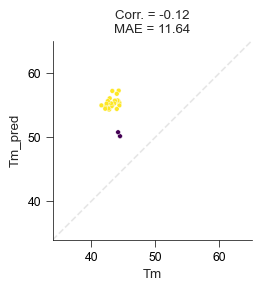

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
modeling.plot_validation_result(val_result_df_nnn, 'Tm', ax=ax, hue='n_mm', palette='viridis')
util.beutify(ax, x_locator=10, y_locator=10)
# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_by_n_mm.pdf')

IndexError: cannot do a non-empty take from an empty axes.

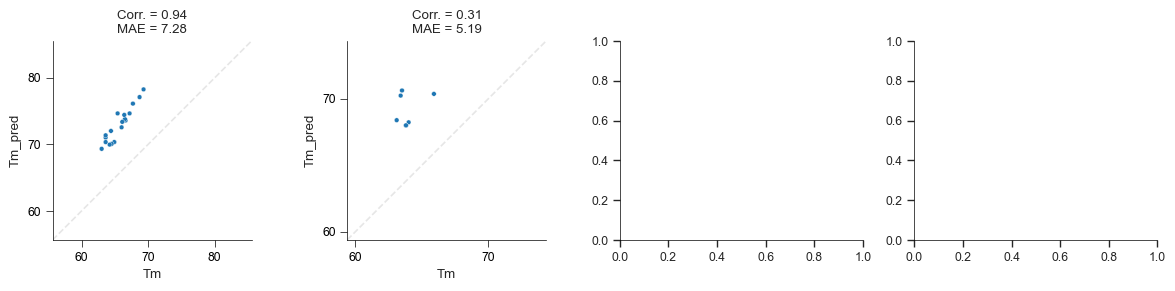

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for n in range(4):
    modeling.plot_validation_result(val_result_df_nnn.query('n_mm == %d'%n), 'Tm', ax=ax[n], 
                                    lim=None)
    util.beutify(ax[n], x_locator=10, y_locator=10)

# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_split_by_n_mm_centered.pdf')

# Extra: NN & NNN for WC and MM

In [131]:
wcmm_df = mydata.arr.query('Series == "WatsonCrick" | Series == "MisMatches"')
wcmm_df['n_mm'] = wcmm_df.TargetStruct.apply(lambda x: int((x.count('.')-4) / 2))
wcmm_df = wcmm_df.query('n_mm <= 1')

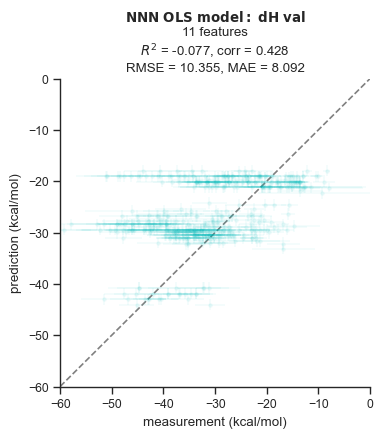

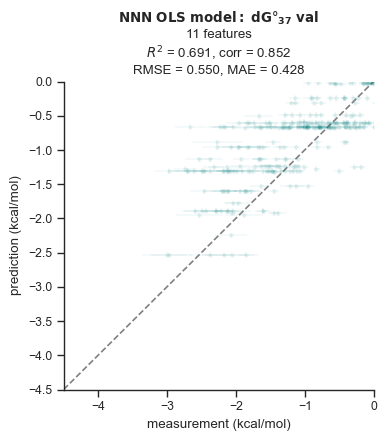

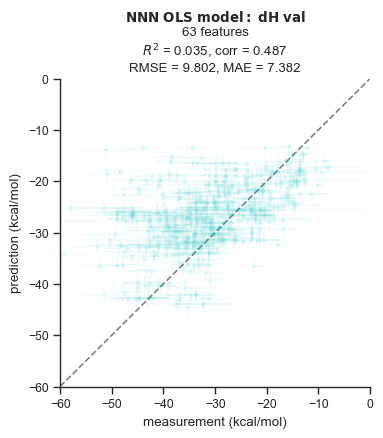

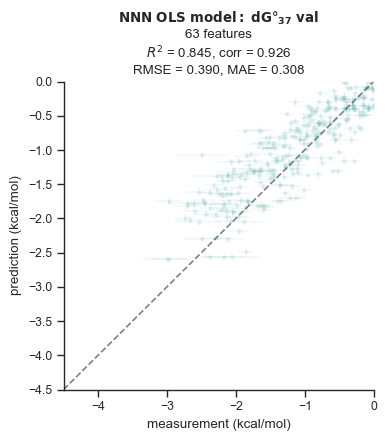

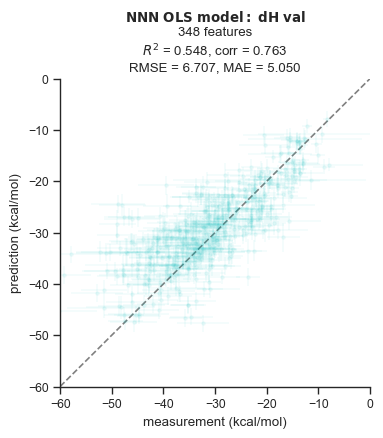

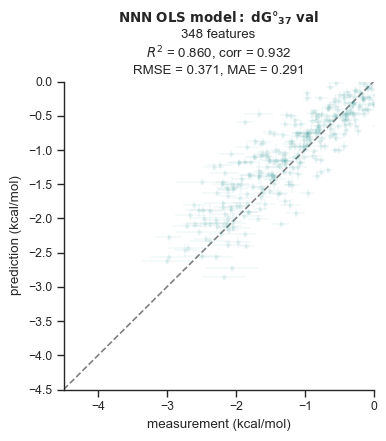

In [262]:
stack_size_list = [1, 2, 3]
lr_dict_list = []

for stack_size in stack_size_list:
    lr_dict = dict()
    feats = mf.get_feature_count_matrix(wcmm_df, 'get_mismatch_stack_feature_list', stack_size=stack_size, fit_intercept=True, symmetry=True)
    
    for p,p_full in dict(dH='dH', dG='dG_37').items():
        lr_dict[p] = mf.fit_param(wcmm_df, mydata.data_split_dict, p_full, feats)
    
    lr_dict_list.append(lr_dict)

In [254]:
val_df = mydata.get_df_by_split(wcmm_df, mydata.data_split_dict, data_split='val')

In [265]:
lr_dict_list[0]['dG'].coef_df

,dG_37
A_A,1.114663
A_C,1.646624
A_G,0.467404
A_T,-0.280763
C_C,1.749325
C_G,-0.925888
C_T,1.361179
G_G,0.324362
G_T,0.942883
T_T,1.009204


In [278]:
def test_param(param):
    fig, ax = plt.subplots(2, 3, figsize=(6,4), sharex=True, sharey=True)
    val_res_dict = dict()
    for i,n in enumerate([0, 1]):
        for j,stack_size in enumerate(stack_size_list):
            print('n_mm = %d, stack_size = %d' % (n, stack_size))
            print(len(val_df.query('n_mm == %d' % n)))
            val_res_df = modeling.make_model_validation_df(
                val_df.query('n_mm == %d' % n),
                model='linear_regression',
                model_kwargs=dict(lr_dict=lr_dict_list[j], 
                                  feature_method='get_mismatch_stack_feature_list',
                                  stack_size=stack_size,
                                  fit_intercept=True,
                                  symmetry=True),
            )
            val_res_dict['n_mm_%d_stack_size_%d' % (n, stack_size)] = modeling.get_metric_dict(val_res_df, param)
            modeling.plot_validation_result(val_res_df, param, ax=ax[i,j])
            util.beutify(ax[i,j])

    util.save_fig('./fig/Fig4/stack_size_wc_mm/scatter_%s.pdf' % param)
    val_result_df = pd.DataFrame(val_res_dict).T
    val_result_df['n_mm'] = [0,0,0,1,1,1]
    val_result_df['stack_size'] = [1,2,3,1,2,3]
    return val_result_df

def normalize_metric_2_stack_1(val_result_df):
    norm_vec = val_result_df[metric].values
    norm_vec[:3] = norm_vec[:3] / norm_vec[0]
    norm_vec[3:] = norm_vec[3:] / norm_vec[3]
    norm_vec *= 100
    val_result_df[metric+'_norm'] = norm_vec
    
    return val_result_df

n_mm = 0, stack_size = 1
96
n_mm = 0, stack_size = 2
96
n_mm = 0, stack_size = 3
96
n_mm = 1, stack_size = 1
363
n_mm = 1, stack_size = 2
363
n_mm = 1, stack_size = 3
363
n_mm = 0, stack_size = 1
96
n_mm = 0, stack_size = 2
96
n_mm = 0, stack_size = 3
96
n_mm = 1, stack_size = 1
363
n_mm = 1, stack_size = 2
363
n_mm = 1, stack_size = 3
363


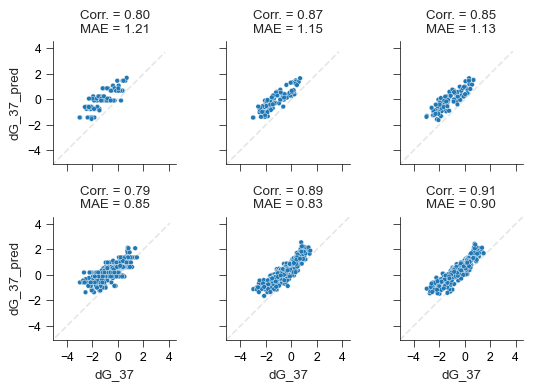

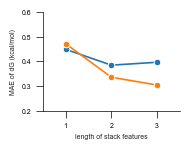

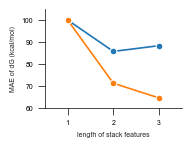

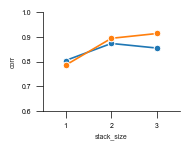

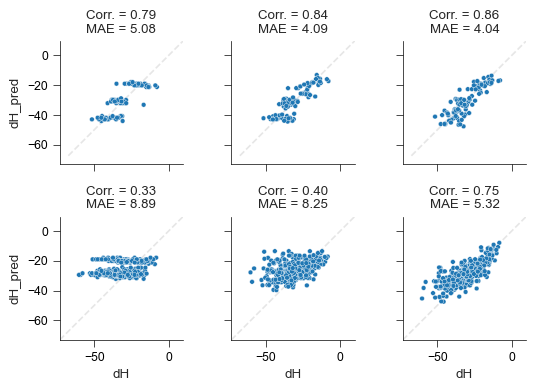

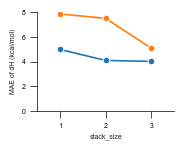

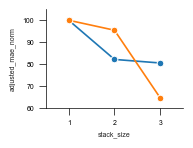

In [307]:
param = 'dG_37'
val_result_df = test_param(param)

metric = 'adjusted_mae'
norm_suffix = ''

fig, ax = plt.subplots()
sns.lineplot(data=val_result_df, x='stack_size', y=metric+norm_suffix, hue='n_mm', marker='o')
ax.set_ylim([.2,.6])
ax.set_xlim([.5,3.5])
ax.set_xlabel('length of stack features')
ax.set_ylabel('MAE of dG (kcal/mol)')
ax.get_legend().remove()
util.beutify(ax, x_locator=1, shrink=True)
util.save_fig('./fig/Fig4/stack_size_wc_mm/%s%s_%s_vs_stack_size_wc_single_mm.pdf' % (param, norm_suffix, metric))

metric = 'adjusted_mae'
norm_suffix = '_norm'
val_result_df = normalize_metric_2_stack_1(val_result_df)

fig, ax = plt.subplots()
sns.lineplot(data=val_result_df, x='stack_size', y=metric+norm_suffix, hue='n_mm', marker='o')
ax.set_ylim([60,105])
ax.set_xlim([.5,3.5])
ax.set_xlabel('length of stack features')
ax.set_ylabel('MAE of dG (kcal/mol)')
ax.get_legend().remove()
util.beutify(ax, x_locator=1, shrink=True)
util.save_fig('./fig/Fig4/stack_size_wc_mm/%s%s_%s_vs_stack_size_wc_single_mm.pdf' % (param, norm_suffix, metric))

metric = 'corr'
fig, ax = plt.subplots()
sns.lineplot(data=val_result_df, x='stack_size', y=metric, hue='n_mm', marker='o')
ax.set_ylim([0.6,1])
ax.set_xlim([.5,3.5])
ax.get_legend().remove()
util.beutify(ax, x_locator=1, shrink=True)
util.save_fig('./fig/Fig4/stack_size_wc_mm/%s_%s_vs_stack_size_wc_single_mm.pdf' % (param, metric))

param = 'dH'
val_result_df = test_param(param)

# dH mae
norm_suffix = ''
metric = 'adjusted_mae'

fig, ax = plt.subplots()
sns.lineplot(data=val_result_df, x='stack_size', y=metric+norm_suffix, hue='n_mm', marker='o')
ax.set_ylim([0,8])
ax.set_xlim([.5,3.5])
ax.get_legend().remove()
ax.set_ylabel('MAE of dH (kcal/mol)')
util.beutify(ax, x_locator=1, shrink=True)
util.save_fig('./fig/Fig4/stack_size_wc_mm/%s_%s%s_vs_stack_size_wc_single_mm.pdf' % (param, norm_suffix, metric))

# dH mae
metric = 'adjusted_mae'
norm_suffix = '_norm'
val_result_df = normalize_metric_2_stack_1(val_result_df)

fig, ax = plt.subplots()
sns.lineplot(data=val_result_df, x='stack_size', y=metric+'_norm', hue='n_mm', marker='o')
ax.set_ylim([60,105])
ax.set_xlim([.5,3.5])
ax.get_legend().remove()
# ax.set_ylabel('MAE of dH (kcal/mol)')
util.beutify(ax, x_locator=1, shrink=True)
util.save_fig('./fig/Fig4/stack_size_wc_mm/%s_norm_%s_vs_stack_size_wc_single_mm.pdf' % (param, metric))

In [105]:
# mm_val_df = val_df.query('Series == "MisMatches"')
# mm_val_df['n_mm'] = mm_val_df.TargetStruct.apply(lambda x: (x.count('.')-4) / 2)


# val_res_df = modeling.make_model_validation_df(
#     mm_val_df.query('n_mm == 1'),
#     model='linear_regression',
#     model_kwargs=dict(lr_dict=lr_dict_list[2], feature_method='get_mismatch_stack_feature_list', stack_size=3),
# )

# modeling.plot_validation_result(val_res_df, 'dG_37')

# wandb results

## % training data

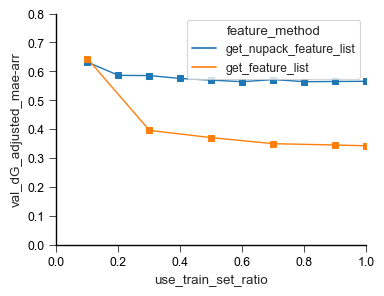

In [10]:
wandb_df = pd.read_csv('./data/wandb/wandb_export_2023-10-31T22_27_44.865-07_00.csv')

query = 'use_train_set_ratio <= 1'

fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(data=wandb_df.query(query), 
             x='use_train_set_ratio', y='val_dG_adjusted_mae-arr',
            ax=ax, hue='feature_method', marker='s', markeredgecolor=None,linewidth=1)
ax.set_ylim(bottom=0, top=.8)
# ax.set_ylim(bottom=0)
ax.set_xlim([0,1])
plotting.beutify(ax)
util.save_fig('./fig/Fig4/mae.pdf')

## val result scatter plot

In [11]:
def plot_val_result_scatter(run_name, p='Tm', 
                            kalvin_Tm=False, center_Tm=True):
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

    val_result_df = val_result_df.join(mydata.annotation[['Series']])
    
    df_q = val_result_df.query('DatasetName == "arr"')

    df_q = df_q.query(f'{p}_pred < 300 and {p}_pred > -300')

    # arr by Series
    fig, ax = plt.subplots(1, 5, figsize=(9,2), sharey=False, sharex=False)
    for i,s in enumerate(['WatsonCrick', 'MisMatches', 'Bulges', 'TETRAloop', 'TRIloop']):
        sns.scatterplot(
            data=df_q.query(f'Series == "{s}"'),
            x=p,
            y=f'{p}_pred',
            color='darkmagenta',
            lw=.1,
            ax=ax[i]
        )
        # ax[i].axis('square')
        if p == 'Tm':
            tick_spacing = 20
        else:
            tick_spacing = 2
            
        util.beutify(ax[i], x_locator=tick_spacing, y_locator=tick_spacing, 
                     force_same_xy=True, add_margin=.2)
        ax[i].set_title(s)
    fig.tight_layout()
    
    # all of lit_uv and ov
    fig, ax = plt.subplots(1, 2, figsize=(4,1.8), sharey=False, sharex=False)
    for i,dn in enumerate(['lit_uv', 'ov']):
        df_q = val_result_df.query(f'DatasetName == "{dn}"')
            
        if kalvin_Tm:
            df_q.Tm_pred -= 273.15


        if center_Tm:
            Tm_med = np.nanmedian(df_q.Tm)
            df_q.Tm_pred += Tm_med - np.nanmedian(df_q.Tm_pred)
        
        sns.scatterplot(
            data=df_q,
            x='Tm',
            y='Tm_pred',
            color='indigo',
            lw=.1,
            ax=ax[i]
        )
        ax[i].axis('square')
        util.beutify(ax[i], x_locator=20, y_locator=20, 
                     force_same_xy=True, add_margin=.1)
        ax[i].set_title(dn)
    fig.tight_layout()

    # ov by n_mm
    fig, ax = plt.subplots(1, 4, figsize=(6,1.5), sharey=True, sharex=True)
    df_q = val_result_df.query('DatasetName == "ov"')
    df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
    if kalvin_Tm:
        df_q.Tm_pred -= 273.15
        
    if center_Tm:
        Tm_med = np.nanmean(df_q.Tm)
        df_q.Tm_pred += Tm_med - np.nanmean(df_q.Tm_pred)
        
    for n in range(4):
        sns.scatterplot(
            data=df_q.query('n_mm == %d' % n),
            x='Tm',
            y='Tm_pred',
            color='darkslateblue',
            lw=.1,
            ax=ax[n]
        )
        lim = (35,80)
        ax[n].set_xlim(lim)
        ax[n].set_ylim(lim)
        util.beutify(ax[n], x_locator=10, y_locator=10)
        ax[n].set_title('%d mismatch(s)' % n)

In [15]:
mydata = tnn.MyData()
mydata.load_everything()

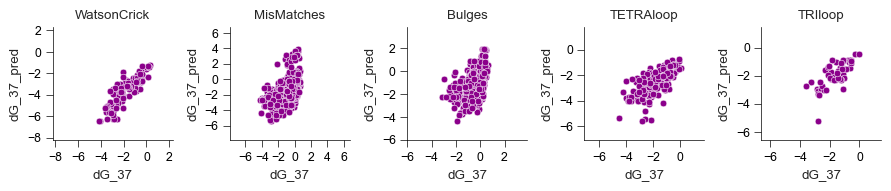

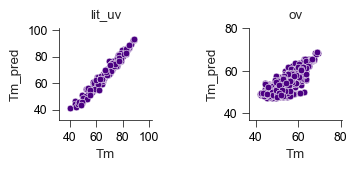

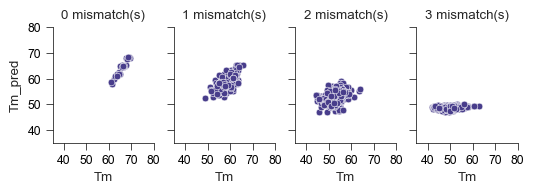

In [16]:
run_name = 'dna04'
plot_val_result_scatter(run_name, p='dG_37', kalvin_Tm=True)
util.save_multi_image('./fig/Fig4/%s_val_result.pdf'%run_name)

## bar plot

In [17]:
wandb_df.set_index('Name', inplace=True)

In [18]:
run_name_list = ['dna04', 'apricot-frost-50', 'fresh-puddle-65']

run_metric_dict = {k:None for k in run_name_list}

for run_name in run_name_list:
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    metric_dict = modeling.get_metric_dict(
        val_result_df.query('DatasetName == "arr"'),
        'dG_37'
    )
    run_metric_dict[run_name] = metric_dict

run_metric_dict

{'dna04': defaultdict(None,
             {'bias': -0.6273588099905685,
              'corr': 0.6517242959735569,
              'rmse': 1.3178089334125136,
              'adjusted_rmse': 1.1588965909472013,
              'mae': 1.0495348812678207,
              'adjusted_mae': 0.8824959628461602}),
 'apricot-frost-50': defaultdict(None,
             {'bias': 2.7395017829017174,
              'corr': 0.8155316275765708,
              'rmse': 2.8385435860789796,
              'adjusted_rmse': 0.7432763090186721,
              'mae': 2.7396599508407027,
              'adjusted_mae': 0.5639831414158113}),
 'fresh-puddle-65': defaultdict(None,
             {'bias': -0.04505189176098434,
              'corr': 0.906142302992639,
              'rmse': 0.4567987931180157,
              'adjusted_rmse': 0.45457173739997553,
              'mae': 0.3464175487116724,
              'adjusted_mae': 0.34201845792951163})}

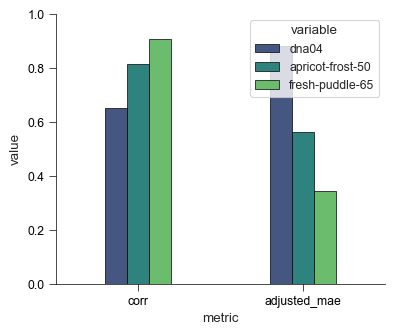

In [420]:
modeling.plot_metric_bar(run_metric_dict, metric_name_list=['corr', 'adjusted_mae'])
plt.ylim((0,1))
util.save_fig('./fig/Fig4/metric.svg')

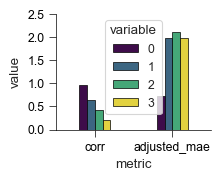

In [441]:
run_name_list = ['dna04', 'apricot-frost-50', 'fresh-puddle-65']
run_name = run_name_list[0]

val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
df_q = val_result_df.query('DatasetName == "ov"')
df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
run_metric_dict = {k:None for k in range(4)}

for n_mm in range(4):
    
    metric_dict = modeling.get_metric_dict(
        df_q.query(f'n_mm == {n_mm}'),
        'Tm'
    )
    run_metric_dict[n_mm] = metric_dict

run_metric_dict

_,ax = plt.subplots(figsize=(2,1.5))
modeling.plot_metric_bar(run_metric_dict, metric_name_list=['corr', 'adjusted_mae'], ax=ax)
util.beutify(ax, y_locator=.5)
plt.ylim((0,2.5))
util.save_fig('./fig/Fig4/metric_ov_%s.svg'%run_name)

# Parameter visualization

In [3]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/dna-nnn-reg1e-1.json'

In [4]:
p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)

NameError: name 'fileio' is not defined

## Hairpin mismatch

In [ ]:
key = 'interior_1_1'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index()

In [ ]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [ ]:
def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    if stem_size == 1:
        return seq[0] + seq[-1] # avoid problem with indexing at the end
    else:
        return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]

### Note that closing pair and loop are swapped when it's hairpin mismatch because of the different order NUPACK writes the sequence
loop_size = 4
df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=loop_size))
df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=loop_size, closing_stack_size=1))
df.sort_values(by='loop', inplace=True)
df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1]+'/'+x.closing_stack, axis=1)
df['loop_center'] = df['loop'].apply(lambda x: x[1:3])
# df = df[df.loop.apply(lambda x: not x in ['AT','TA','CG','GC'])]

In [ ]:
df = df[df.closing_stack.apply(lambda x: x in ['AT','TA','CG','GC'])]

In [ ]:
offset = np.nanmean((df.pivot_table(index='closing_stack', columns='loop', values='new') - df.pivot_table(index='closing_stack', columns='loop', values='old')).values)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=False)
# args = dict(vmin=-1.2, vmax=0.2, cmap='cividis', square=False)
args=dict()
sns.heatmap(df.pivot_table(index='closing_stack', columns='loop', values='new').T, ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(df.pivot_table(index='closing_stack', columns='loop', values='old').T, ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')
# for a in ax:
#     a.set_xticks([])
#     a.set_yticks([])
util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_hairpin_mismatch.pdf')

## Compare interior vs hairpin mismatch parameters

In [ ]:
mm_compare_df = pd.DataFrame(data=
             dict(interior_mm_old=p_old_dict['dG']['interior_mismatch'], 
                  interior_mm_new=p_new_dict['dG']['interior_mismatch'],
                  hairpin_mm_old=p_old_dict['dG']['hairpin_mismatch'], 
                  hairpin_mm_new=p_new_dict['dG']['hairpin_mismatch'],
                 )
            )

In [ ]:
mm_compare_df = mm_compare_df.query('interior_mm_new != 0')

In [ ]:
"""
Are all those zeros in interor_mm_new due to underdetermined matrix?
No, they are just WC pairs. LOL. Get rid of them when plotting. 
"""
kwargs = dict(color_by_density=False, lim=(-4,1))
plotting.plot_colored_scatter_comparison(data=mm_compare_df, x='interior_mm_old', y='hairpin_mm_old', **kwargs)

plotting.plot_colored_scatter_comparison(data=mm_compare_df, x='interior_mm_new', y='hairpin_mm_new', **kwargs)

Seems that hairpin mismatches are consistently higher than interior.

## WC [clean]

In [59]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/dna-nnn-stack.json'

p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)

key = 'stack'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

def is_wc_stack(stack):
    return stack[0] == util.rcompliment(stack[-1]) and stack[1] == util.rcompliment(stack[-2])

df = df.loc[df.RefSeq.apply(is_wc_stack)]

# df.new -= np.mean(df.new) - np.mean(df.old)

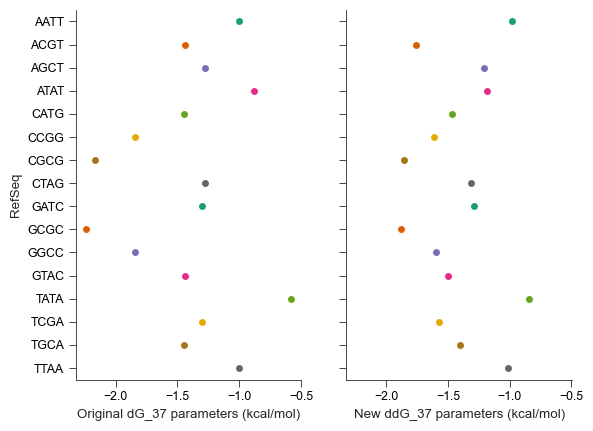

In [60]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
palette = 'Dark2'
sns.stripplot(data=df, orient='h', y='RefSeq', x='old', ax=ax[0], palette=palette)
ax[0].set_xlabel('Original dG_37 parameters (kcal/mol)')
sns.stripplot(data=df, orient='h', y='RefSeq', x='new', ax=ax[1], palette=palette)
ax[1].set_xlabel('New ddG_37 parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax, x_locator=.5)

util.save_fig('./fig/Fig4/WC/WC_original_vs_new_dG_37.pdf')

## Interior mismatch [clean]

In [35]:
key = 'interior_1_1'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

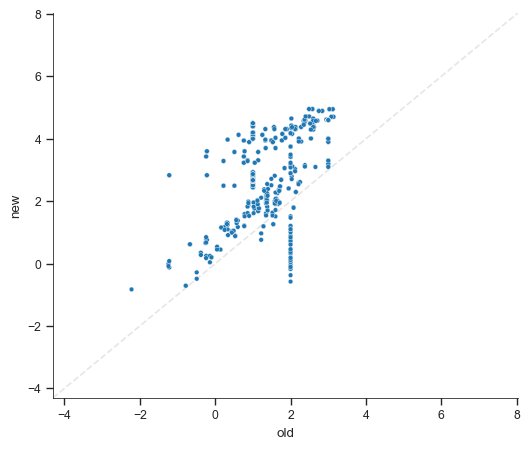

In [36]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [37]:
def get_mm(seq):
    if seq[4] != util.rcompliment(seq[1]):
        return f'{seq[1]}·{seq[4]}'
    else:
        return np.nan

def get_context(seq):
    if seq[-1] == util.rcompliment(seq[0]) and seq[3] == util.rcompliment(seq[2]):
        return f'{seq[0]}{seq[-1]}x{seq[2]}{seq[3]}'
    else:
        return np.nan

df['mm'] = df.RefSeq.apply(get_mm)
df['context'] = df.RefSeq.apply(get_context)

df = df.dropna()

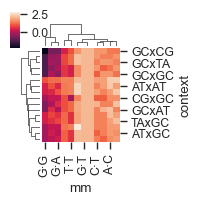

In [38]:
pivot_new = df.pivot_table(index='context', columns='mm', values='new')
pivot_old = df.pivot_table(index='context', columns='mm', values='old')
clustergrid = sns.clustermap(pivot_old, figsize=(2,2))

reordered_index, reordered_columns = util.get_reordered_ind(clustergrid, pivot_new)

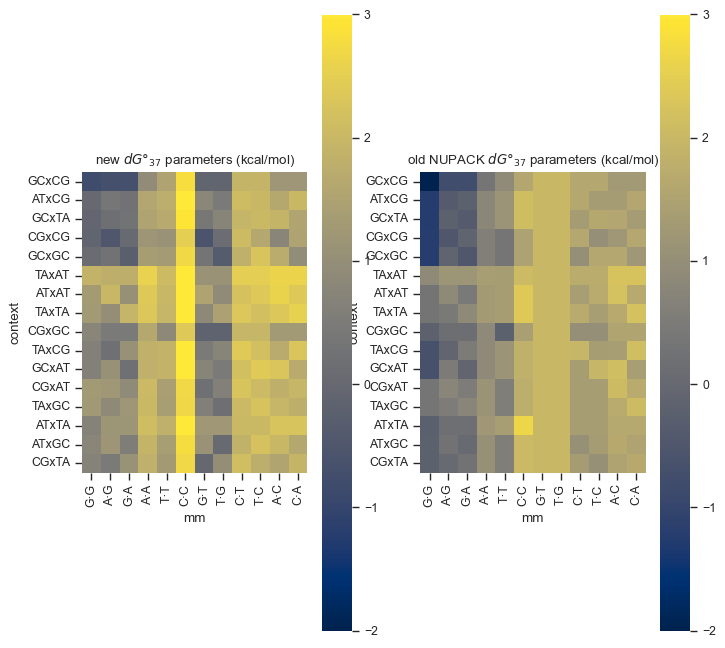

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharex=False)
args = dict(vmin=-2, vmax=3, cmap='cividis', square=True)

sns.heatmap(pivot_new.loc[reordered_index, reordered_columns], ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_old.loc[reordered_index, reordered_columns], ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')

util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_single_mismatch.pdf')